# SHA-256 en Python

### Auteur : Léopold Terpereau
Basé sur le rapport du National Institute of Standards and Technology:
    https://csrc.nist.gov/csrc/media/publications/fips/180/2/archive/2002-08-01/documents/fips180-2.pdf

Chaque définition de fonction est suivie d'un exemple

## Modules utilisés

In [288]:

import numpy as np
import math
import matplotlib.pyplot as plt
import random as r
import hashlib
import re
import time

## I. Pré-traitement

### Conversion 
Conversion du message en ascii puis en binaire, en itérant sur chaque caractère

In [154]:
def strBin(message): 
    return (''.join('0'+str(bin(ord(car)))[2:] for car in message)) 

Exemple :
Conversion en binaire du message 'abc'

In [155]:
strBin('abc')

'011000010110001001100011'

### Rembourrage
Rembourre le message selon le procédé de Padding :
 
Ajoute un 1 après le message converti en binaire, puis ajoute des 0, et enfin la longueur du message initial en binaire sur 64 bits

In [156]:
def rembourrage(message):
    rembourré=strBin(message)               #utilisation de la fonction précedente
    l=len(rembourré)+2**64                  #ajout de 2**64 pour coder la longueur sur 64 bits
    rembourré+='1'
    while len(rembourré)%512!=448:          #ajout de 0 jusqu'à une longueur de 448 modulo 512
        rembourré+='0'
    rembourré+=bin(l)[-64:]                 #ajout de la longueur l en binaire du message initial
    return(rembourré)

Exemple :
Rembourrage du message 'abc'

In [157]:
test=rembourrage('abc')
print(test)
len(test)

01100001011000100110001110000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000011000


512

### Découpage en blocs
Découpe un ensemble de bits en blocs de 512 bits

In [158]:
def découpageBlocs(rembourré):
    listeblocs=[]
    for i in range(len(rembourré)//512):
        listeblocs.append(str(rembourré[i*512:(i+1)*512]))
    return listeblocs  #liste contenant les blocs

Exemple :
Découpage du message 'abc' rembourré 

On remarque qu'on a alors une liste d'1 bloc de 512 bits

In [159]:
test=découpageBlocs(test)
print(test)
len(test)

['01100001011000100110001110000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000011000']


1

### Division en mots
Un bloc de 512 bits est divisé en une liste 'mots' de 16 mots de 32 bits

In [160]:
def division32bits(bloc):
    mots=[]
    for i in range(512//32):
        mots.append(str(bloc[i*32:(i+1)*32]))
    return mots                                #liste contenant les mots

Exemple :
Découpage du bloc précédent

In [161]:
division32bits(test[0])


['01100001011000100110001110000000',
 '00000000000000000000000000000000',
 '00000000000000000000000000000000',
 '00000000000000000000000000000000',
 '00000000000000000000000000000000',
 '00000000000000000000000000000000',
 '00000000000000000000000000000000',
 '00000000000000000000000000000000',
 '00000000000000000000000000000000',
 '00000000000000000000000000000000',
 '00000000000000000000000000000000',
 '00000000000000000000000000000000',
 '00000000000000000000000000000000',
 '00000000000000000000000000000000',
 '00000000000000000000000000000000',
 '00000000000000000000000000011000']

### Annexe : Définition des fonctions binaires bit à bit

In [162]:
a='11'*16
b='01'*16
c='0'*16+'1'*16
print('a : ' + a)
print('b : ' + b)
print('c : ' + c)

a : 11111111111111111111111111111111
b : 01010101010101010101010101010101
c : 00000000000000001111111111111111



Addition modulo $2^{32}$ de a et b

In [163]:
def ADD32(a,b): 
    if len(a)!=len(b) or len(a)!=32:
        raise Exception
    a=a[::-1]
    b=b[::-1]
    s=''
    k=0
    for i in range(32):
        if a[i]==b[i] and a[i]=='1':
            if k==1:
                s+='1'
            else:
                s+='0'
            k=1
        elif a[i]==b[i] and a[i]=='0':
            if k==1:
                s+='1'
            else:
                s+='0'
            k=0
        else:
            if k==1:
                s+='0'
            else:
                s+='1'
    s=s[::-1]
    return s

In [164]:
print('  ' + a)
print('+ ' + b)
print('  ' + ADD32(a,b))

  11111111111111111111111111111111
+ 01010101010101010101010101010101
  01010101010101010101010101010100


Fonction ET, NON, OU, OU EXCLUSIF binaires

In [165]:

def NOT(a):#a est codé en binaire 
    l=len(a)
    s=''
    for i in range(l):
        s+=str(1-int(a[i]))
    return s

def AND(a,b):#a et b sont codés en binaire 
    if len(a)!=len(b):
        raise Exception
    l=len(a)
    s=''
    for i in range(l):
        s+=str(int(a[i])*int(b[i]))
    return s

def OR(a,b):#a et b sont codés en binaire 
    if len(a)!=len(b):
        raise Exception
    l=len(a)
    s=''
    for i in range(l):
        if int(a[i])==1 or int(b[i])==1:
            s+='1'
        else :
            s+='0'
    return s

def XOR(a,b):#a est codé en binaire
    if len(a)!=len(b):
        raise Exception
    l=len(a)
    s=''
    for i in range(l):
        s+=str((int(a[i])+int(b[i]))%2)
    return s

def multiXOR(L): #liste de mots binaires supposés de même longueur
    l=len(L[0])
    s=''
    for i in range(l):
        val=0
        for mot in L:
            val+=int(mot[i])
        s+=str(val%2)
    return s




In [166]:
print('    a: ' + a)
print('NON a: ' + NOT(a))

    a: 11111111111111111111111111111111
NON a: 00000000000000000000000000000000


In [167]:
print('   ' + a)
print('ET ' + b)
print('   ' + AND(a,b))

   11111111111111111111111111111111
ET 01010101010101010101010101010101
   01010101010101010101010101010101


In [168]:
print('   ' + a)
print('OU ' + b)
print('   ' + OR(a,b))

   11111111111111111111111111111111
OU 01010101010101010101010101010101
   11111111111111111111111111111111


In [169]:
print('      ' + a)
print('OU EX ' + b)
print('      ' + XOR(a,b))

      11111111111111111111111111111111
OU EX 01010101010101010101010101010101
      10101010101010101010101010101010


Fonctions de Rotation et Decalage binaires

$SHIFTR^{n}(x)=x>>n$

$ROTR^{n}(x)=(x>>n) ou (x<<(32-n))$



In [170]:
def DecalageDroite(a,n):
    l=len(a)
    s=''
    s+='0'*n
    s+=str(a[:l-n])
    return s

def RotationDroite(a,n): 
    l=len(a)
    s=''
    s+=str(a[-n:])
    s+=str(a[:l-n])
    return s    

In [171]:
print('      c: ' + c)
print('DecD5 c: ' + DecalageDroite(c,5))
print('RotD5 c: ' + RotationDroite(c,5))

      c: 00000000000000001111111111111111
DecD5 c: 00000000000000000000011111111111
RotD5 c: 11111000000000000000011111111111


Fonctions composées $Sigma$

∑0(x) = ROTR 2(x) ⊕ ROTR 13(x) ⊕ ROTR 22(x)

∑1(x) = ROTR 6(x) ⊕ ROTR 11(x) ⊕ ROTR 25(x)

σ0(x) = ROTR 7(x) ⊕ ROTR 18(x) ⊕ SHR 3(x)

σ1(x) = ROTR 17(x) ⊕ ROTR 19(x) ⊕ SHR 10(x)

In [172]:
def SIGMA0(a):
    a0=RotationDroite(a, 2)
    a1=RotationDroite(a, 13)
    a2=RotationDroite(a, 22)
    a3=multiXOR((a0,a1,a2))
    return a3
    
def SIGMA1(a):
    a0=RotationDroite(a, 6)
    a1=RotationDroite(a, 11)
    a2=RotationDroite(a, 25)
    a3=multiXOR((a0,a1,a2))
    return a3

def sigma0(a):
    a0=RotationDroite(a, 7)
    a1=RotationDroite(a, 18)
    a2=DecalageDroite(a, 3)
    a3=multiXOR((a0,a1,a2))
    return a3
    
def sigma1(a):
    a0=RotationDroite(a, 17)
    a1=RotationDroite(a, 19)
    a2=DecalageDroite(a, 10)
    a3=multiXOR((a0,a1,a2))
    return a3


Fonctions particulières $Choix$ et $Majorité$

Ch(x, y,z) = (x ∧ y) ⊕ (¬x ∧ z)

Maj(x, y,z) = (x ∧ y) ⊕ (x ∧ z) ⊕ ( y ∧ z)

In [173]:

def Choix(a,b,c):
    if len(a)!=len(b) or len(b)!=len(c):
        raise Exception
    l=len(a)
    r=''
    for i in range(l):
        if a[i]=='0':
            r+=c[i]
        else:
            r+=b[i]
    return r



def Maj(a,b,c):
    if len(a)!=len(b) or len(b)!=len(c):
        raise Exception
    l=len(a)
    s=''
    for i in range(l):
        k=0
        if a[i]=='1':
            k+=1
        if b[i]=='1':
            k+=1
        if c[i]=='1':
            k+=1
        if k>1:
            s+='1'
        else:
            s+='0'
    return s

In [174]:
print('->    ' + c)
print('Ch 1  ' + b)
print('Ch 0  ' + a)
print('      ' + Choix(c,b,a))

->    00000000000000001111111111111111
Ch 1  01010101010101010101010101010101
Ch 0  11111111111111111111111111111111
      11111111111111110101010101010101


In [175]:
print(' a   ' + a)
print(' b   ' + b)
print(' c   ' + c)
print('Maj  ' + Maj(a,b,c))

 a   11111111111111111111111111111111
 b   01010101010101010101010101010101
 c   00000000000000001111111111111111
Maj  01010101010101011111111111111111


### Annexe : Fonction d'affichage

In [271]:
def afficheTableau(tab):
    plt.figure(figsize=(10, 10))
    plt.imshow(tab,'Greys',vmin=0,vmax=1)
    
def enBits(liste):
    listeBits=[[] for i in range(len(liste))]
    for i in range(len(liste)):
        for j in range(len(liste[i])):
            listeBits[i].append(float(liste[i][j]))
    return listeBits
            


## II. Expansion
On transforme les 16 mots d'une liste en 64 mots en les recombinant avec une relation de récurrence


In [272]:
def expansion(M): 
    mots=division32bits(M) 
    for t in range(16,64):
        m=ADD32(sigma1(mots[t-2]),mots[t-7])
        m=ADD32(m,sigma0(mots[t-15]))
        m=ADD32(m,mots[t-16])
        mots.append(m)
    return mots

Exemple :
Expansion de la liste des mots précédente

La ième ligne représente le ième mot (0=blanc et 1=noir)

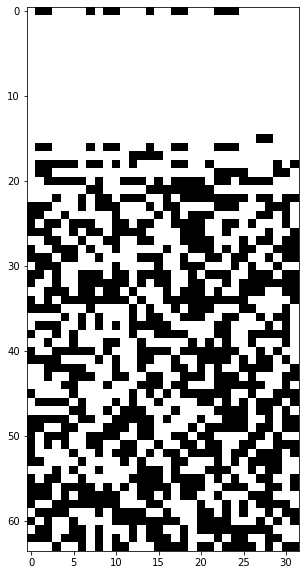

In [273]:
afficheTableau(enBits(expansion(test[0])))

### Importation des constantes de SHA-256


In [274]:
ListeConstantes= open('SHA256 constants.txt').read().split()
K=[]
for k in ListeConstantes:
    K.append(bin(int(k,16)+2**32)[3:])

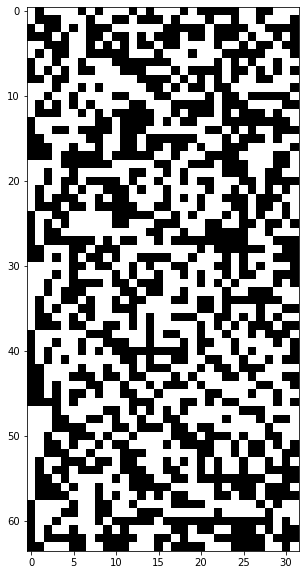

In [275]:
afficheTableau(enBits(K))


## III. Fonction de mise à jour des états du registre
C'est-à-dire la fonction qui transforme les mots en haché, de manière récursive


+ Ai+1 = 1Σ(Ei) + Ch(Ei,Fi,Gi) + Hi + Wi + Ki + Σ0(Ai) + Maj(Ai,Bi,Ci)
+ Bi+1 = Ai
+ Ci+1 = Bi
+ Di+1 = Ci
+ Ei+1 = Σ1(Ei) + Ch(Ei,Fi,Gi) + Hi + Wi + Ki + Di
+ Fi+1 = Ei
+ Gi+1 = Fi
+ Hi+1 = Gi

In [276]:
def MAJetatRegistre(H,M):
    a=H[0]
    b=H[1]
    c=H[2]
    d=H[3]
    e=H[4]
    f=H[5]
    g=H[6]
    h=H[7]
    for t in range(64):
        T1=ADD32(ADD32(h,SIGMA1(e)),ADD32(Choix(e,f,g),ADD32(K[t],M[t])))
        T2=ADD32(SIGMA0(a),Maj(a,b,c))
        h=g
        g=f
        f=e
        e=ADD32(d,T1)
        d=c
        c=b
        b=a
        a=ADD32(T1,T2)
    H[0]=ADD32(a,H[0])
    H[1]=ADD32(b,H[1])
    H[2]=ADD32(c,H[2])
    H[3]=ADD32(d,H[3])
    H[4]=ADD32(e,H[4])
    H[5]=ADD32(f,H[5])
    H[6]=ADD32(g,H[6])
    H[7]=ADD32(h,H[7])
    return H

### Etapes de calcul du haché
On calcule le haché intermédiaire de chaque bloc (de 512 bits), qui est réutilisé comme haché initial pour le traitement du bloc suivant 

Le haché initial du premier bloc est défini par h0 jusqu'à h7, qui correspondent aux mots $a$ à $h$ initialement

In [277]:
def etapes(L):
    l=len(L)
    h0 = bin(int('6a09e667',16)+2**32)[3:]
    h1 = bin(int('bb67ae85',16)+2**32)[3:]
    h2 = bin(int('3c6ef372',16)+2**32)[3:]
    h3 = bin(int('a54ff53a',16)+2**32)[3:]
    h4 = bin(int('510e527f',16)+2**32)[3:]
    h5 = bin(int('9b05688c',16)+2**32)[3:]
    h6 = bin(int('1f83d9ab',16)+2**32)[3:]
    h7 = bin(int('5be0cd19',16)+2**32)[3:]
    H=[h0,h1,h2,h3,h4,h5,h6,h7]
    for i in range(1,l+1):
        M=expansion(L[i-1])
        H=MAJetatRegistre(H,M)
    H=H[0]+H[1]+H[2]+H[3]+H[4]+H[5]+H[6]+H[7]
    return H

Exemple : calcul du haché en bit du message $abc$

In [284]:
R=rembourrage('abc')    
L=découpageBlocs(R)
H=etapes(L)
print(H)
len(H)

1011101001111000000101101011111110001111000000011100111111101010010000010100000101000000110111100101110110101110001000100010001110110000000000110110000110100011100101100001011101111010100111001011010000010000111111110110000111110010000000000001010110101101


256

### Calcul du hexdigest
On transforme le haché final de 256 bits en hexadécimal (suite de 64 caractères)

In [279]:
def digest(H): #renvoie un hexdigest du haché 
    d=hex(int(H, 2))[2:]
    return d

Exemple : calcul du haché en hexadécimal du message $abc$

In [286]:
digest(H)

'ba7816bf8f01cfea414140de5dae2223b00361a396177a9cb410ff61f20015ad'

On peut comparer cette valeur avec la valeur donnée par le module hashlib

In [292]:
hashlib.sha256(b'abc').hexdigest()

'ba7816bf8f01cfea414140de5dae2223b00361a396177a9cb410ff61f20015ad'

## IV. Fonction SHA-256 en Python

Finalement, en condensant les parties précédentes, on a SHA-256 implémenté en Python

In [293]:
def SHA256(m):
    R=rembourrage(m)
    L=découpageBlocs(R)
    H=etapes(L)
    d=digest(H)
    return d

Et voilà le travail :)

In [304]:
SHA256('abc')

'ba7816bf8f01cfea414140de5dae2223b00361a396177a9cb410ff61f20015ad'